## Description:

- Calculates sun's position on panoramic
- Determines visible sky
- Calculates sun glare

In [4]:
import matplotlib.pyplot as plt
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime, timezone
from PIL import Image
import math

def plot_dot_on_image(img_path, xc, yc, color='red', title="Sun's Incidence Point on Cylindrical GSV Panorama"):

    with Image.open(img_path) as img:
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.scatter(xc, yc, color=color, label="Sun's Incidence Point")
        plt.text(xc + 10, yc - 10, f"({int(xc)}, {int(yc)})", color='red', fontsize=12)
        plt.title(title)
        plt.show()

def get_image_width_height(img_path):
    with Image.open(img_path) as img:
        width, height = img.size
    return width, height

def get_sun_position_east(latitude: float, longitude: float, date: datetime):
    altitude = get_altitude(latitude, longitude, date)  # degrees
    azimuth = get_azimuth(latitude, longitude, date)  #  degrees

    # convert to be anticlockwise from east
    azimuth = 90 - azimuth
    if azimuth < 0:
        azimuth = azimuth + 360  

    return altitude, azimuth






### Image Processing:

In [5]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def plot_image(image, title="None"):
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")  # Hide axes for cleaner visualization
    plt.show()

def plot_dot_on_image_obj(img, x, y, title="No Title" , color='red' ):
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.scatter(x, y, color=color, label="Sun's Incidence Point" )
    plt.text(x + 10, y - 10, f"({int(x)}, {int(y)})", color='red', fontsize=12)
    plt.title(title)
    plt.show()

In [6]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def convert_image_to_segmentation_maps(image_path, output_path):
    # Load the model and feature extractor
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load and preprocess the image
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and convert to class predictions
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    predicted_class = torch.argmax(logits, dim=1)  # shape (batch_size, height/4, width/4)

    # Upsample to match input image size
    predicted_class = torch.nn.functional.interpolate(
        predicted_class.unsqueeze(1).float(),  # Add channel dimension
        size=image.size[::-1],  # Match input image dimensions (height, width)
        mode="nearest"
    ).squeeze(1).to(torch.int32)  # Remove channel dimension

    # Convert to numpy array
    segmentation_map = predicted_class[0].cpu().numpy()

    # save the image
    # plt.imsave(output_path, segmentation_map, cmap=cmap, vmin=0, vmax=num_classes - 1)
    # np.save(output_path.replace(".jpg", ".npy"), segmentation_map)
    Image.fromarray(segmentation_map.astype(np.uint8)).save(output_path)

    return segmentation_map



      

In [20]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import ast

from datetime import datetime, timedelta, timezone
import math


def get_sun_position_on_panoramic_with_heading_date_slope(pan_img_path, lat, long, heading, date=datetime.now(timezone.utc), driveway_slope=0):
    driving_direction = heading
    
    altitude, azimuth = get_sun_position_east(lat, long, date)
    
    wc, hc = get_image_width_height(pan_img_path)
    cx = wc/2
    cy = hc/2

    rad_azimuth = math.radians(azimuth)
    rad_altitude = math.radians(altitude)
    rad_driving_direction = math.radians(driving_direction)
    rad_driveway_slope = math.radians(driveway_slope)

    sun_x = (((rad_driving_direction - rad_azimuth) / (2 * math.pi)) * wc) + cx
    sun_y = cy - (((rad_altitude - rad_driveway_slope) / (math.pi/2)) * hc)
    
    return sun_x, sun_y

def determine_sun_position(panoramic_path, lat, long, date, heading, tilt):

    # calculate the sun position for the given time
    xc, yc = get_sun_position_on_panoramic_with_heading_date_slope(panoramic_path, lat, long, heading, date=date, driveway_slope=tilt)

    wc, hc = get_image_width_height(panoramic_path)
    
    # wrap the x-coordinate around the panoramic width
    xc = xc % wc

    #plot it 
    # plot_dot_on_image(panoramic_path, xc, yc)

    return xc, yc

def write_as_csv(filepath, dict):
    df = pd.DataFrame.from_dict(dict, orient='index')
    df.index.name = 'pano_heading_id'
    df.to_csv(filepath)


# returns False is the x,y are in the sky class 
def check_if_sun_is_blocked(segmentation_map, x, y, sky_class=10, building_class=2, tree_class=8):

    # create mask of sky
    sky_masks = (segmentation_map == 10).astype(np.uint8) * 255
    building_masks = (segmentation_map == building_class).astype(np.uint8) * 255
    tree_masks = (segmentation_map == tree_class).astype(np.uint8) * 255
    # plot_image(sky_masks, title="Sky Mask")
    # plot_dot_on_image_obj(sky_masks, x, y, title="Sky Mask", color='red')
    # plot_dot_on_image_obj(building_masks, x, y, title="Sky Mask", color='red')
    # plot_dot_on_image_obj(tree_masks, x, y, title="Sky Mask", color='red')
    
    # plot_image(segmentation_map, title="Segmentation Map")
    # plot_image(sky_masks, title="Sky Mask")
    # plot_image(building_masks, title="Building Mask")
    # plot_image(tree_masks, title="Tree Mask")

    # check if x,y is in the sky mask
    # figure out what object blocked the sun

    x = int(x)
    y = int(y)

    print(f"sky_masks[y, x]: {sky_masks[y, x]} at (y={y}, x={x})")
    print(sky_masks[y,x])

    # Sky is 255, other is 0
    if sky_masks[y,x] == 0:
        print("Sun is blocked by an object")
        # find the object that blocked the sun
        blockage_type = "other"
        
        print(f"building_masks[y, x]: {building_masks[y, x]} at (y={y}, x={x})")
        print(f"tree_masks[y, x]: {tree_masks[y, x]} at (y={y}, x={x})")

        if building_masks[y,x] == 255:
            print(" [check] Sun is blocked by a building")   
            blockage_type = "building"
        elif tree_masks[y,x] == 255:
            print(" [check] Sun is blocked by a tree")
            blockage_type = "tree"
        return True, blockage_type
    return False, "none"

    


def convert_heading_to_anticlockwise_from_east(heading):
    # Convert the heading to anti-clockwise from east
    heading = 90 - heading
    if heading < 0:
        heading += 360

    # print(f"Heading (anti-clockwise from east): {heading}")
    return heading


def add_sun_glare_row_to_dataset(sun_glare_dict, pano_id, segment_heading, lat, long, has_sun_glare, angle_risk ,blockage_type = "none", ):
    row_id = f"{pano_id}_{segment_heading}"
    sun_glare_dict[row_id] = {
        "lat": lat,
        "long": long,
        "has_sun_glare": has_sun_glare,
        "pano_id": pano_id,
        "heading": segment_heading,
        "angle_risk": angle_risk, # true if sun has proper angle to cause glare
        "blockage_type": blockage_type
    }

    print(f"{row_id}: lat: {lat}, long: {long}, has_sun_glare: {has_sun_glare}, angle_risk: {angle_risk}, blockage_type: {blockage_type}")

def angle_difference(angle1, angle2):
    diff = (angle2 - angle1 + 180) % 360 - 180
    return abs(diff)


# returns True if sun glare is detected at a panoramic image
def calculate_sun_glare_given_heading_panoramic_row(panoramic_img_path, segment_heading, pano_row, date_time, segmentation_map_directory_path):
    lat = pano_row["lat"]
    long = pano_row["long"] 
    panoramic_heading = pano_row["heading"]
    tilt = pano_row["tilt"]
    pano_id = pano_row["pano_id"]

    sun_x, sun_y = determine_sun_position(panoramic_img_path, lat, long, date_time, panoramic_heading, tilt)
    altitude, azimuth = get_sun_position_east(lat, long, date_time)

    h_glare = angle_difference(azimuth, segment_heading)
    v_glare = angle_difference(altitude, tilt)

    if (h_glare < 25) and (v_glare < 25):
        segmentation_map_path = f"{segmentation_map_directory_path}\{pano_id}.png"
        segmentation_map = np.array(Image.open(segmentation_map_path))
        sun_glare_blocked, _ = check_if_sun_is_blocked(segmentation_map, sun_x, sun_y)
        return not sun_glare_blocked
    else:
        return False

# TODO-WORKING
# looks at all headings at panoramic
def check_if_any_sun_glare_at_panoramic_with_datetime(pano_row, date_time, segmentation_dataset_path, panoramic_img_path):
    print(f"Checking for sun glare at {date_time}")
    print(pano_row['segment_headings'])
    segment_headings = pano_row['segment_headings']

    for heading in segment_headings:
        has_sun_glare = calculate_sun_glare_given_heading_panoramic_row(panoramic_img_path, heading, pano_row, date_time, segmentation_dataset_path)
        if has_sun_glare:
            return True
    return False
    
           



def calculate_sun_glare_for_a_single_panoramic_image(sun_glare_dict,segmentation_map_directory_path, panoramic_file, pano_id, lat, long, panoramic_heading, tilt, date_time, segment_headings):

    # TODO remember each image can have multiple headings, so we need to check sun glare at each heading

    sun_x, sun_y = determine_sun_position(panoramic_file, lat, long, date_time, panoramic_heading, tilt)
    altitude, azimuth = get_sun_position_east(lat, long, date_time)
    # each panoramic image can have multiple headings (like an intersection or 2 lane road)
    # we want to save each heading and the sun glare for that heading
    for segment_heading in segment_headings:
        print("Segment Heading: ", segment_heading)
        
        # print(f"|{azimuth}-{segment_heading}|={abs(azimuth - segment_heading)}")
        # print(f"|{altitude}-{tilt}|={abs(altitude - tilt)}")
        # segment_heading = float(segment_heading)
        # h_glare = abs(azimuth - segment_heading)
        # v_glare = abs(altitude - tilt)

        h_glare = angle_difference(azimuth, segment_heading)
        v_glare = angle_difference(altitude, tilt)
        print(f"difference({azimuth}, {segment_heading}) = {h_glare}")
        print(f"H: {h_glare}, V: {v_glare}")

        if (h_glare < 25) and (v_glare < 25):
            # angle potential for sun glare, lets check if something blocks it
            # first read the segmentation map from storage
            segmentation_map_path = f"{segmentation_map_directory_path}\{pano_id}.png"
            
            segmentation_map = np.array(Image.open(segmentation_map_path))


            # with Image.open(segmentation_map_path) as img:


                # reloaded_map = np.load(output_path.replace(".png", ".npy"))
              
                # segmentation_map = np.array(img)
                # plot_image(segmentation_map, title="Segmentation Map of Panoramic Image")

            sun_glare_blocked, blockage_type = check_if_sun_is_blocked(segmentation_map, sun_x, sun_y)

            if sun_glare_blocked:
                print(f"Sun glare blocked by a {blockage_type}")
                # plot_dot_on_image(panoramic_file, sun_x, sun_y, color='yellow', title=f"Sun Glare at {date_time}")
                # TODO 
                add_sun_glare_row_to_dataset(sun_glare_dict, pano_id, segment_heading, lat, long, False, True, blockage_type)
            else:
                print("Sun glare not blocked")
                # plot_dot_on_image(panoramic_file, sun_x, sun_y, color='red', title=f"Sun Glare at {date_time}")
                add_sun_glare_row_to_dataset(sun_glare_dict, pano_id, segment_heading, lat, long, True, True, blockage_type)
        else:
            print("No Chance of sun glare detected")
            # plot_dot_on_image(panoramic_file, sun_x, sun_y, color='green', title=f"Sun Glare at {date_time}")
            # False, since angle is not right for sun glare
            add_sun_glare_row_to_dataset(sun_glare_dict, pano_id, segment_heading, lat, long, has_sun_glare=False , angle_risk=False, blockage_type="none")


# calculates and stores sun glare for all panoramic data at a given date and time
# Note: date_time is in UTC
def calculate_sun_glare_for_panoramic_data_at_date_time(panoramic_data_file, date_time, segmentation_map_directory_path,segmentation_dataset_path, panoramic_imgs_directory_path,sunglare_dataset_output_path):
    pano_data = pd.read_csv(panoramic_data_file)
    print(f"Calculating sun glare for all panoramic images at {date_time}")
    
    segments = pd.read_csv(segmentation_dataset_path)
    sun_glare_dict = {}

    # print(pano_data)
    for index, panoramic in pano_data.iterrows():
        print(f"=== index: {index} ===")
        
        pano_id = panoramic["pano_id"]
        segment_id = panoramic["segment_id"]
        lat = panoramic["lat"]
        long = panoramic["long"]
        # heading is already anticlockwise from east
        heading = panoramic["heading"]
        tilt = panoramic["tilt"]
        year = panoramic["year"]
        month = panoramic["month"]
        print(f"panoramic_heading: {heading}")
        segment = segments.loc[segments['segment_id'] == segment_id]
        segment_headings = segment['headings'].apply(ast.literal_eval)
        segment_headings = segment_headings.iloc[0]

        print(f"Segment Headings: {segment_headings}")
        # convert segment headings to anticlockwise from east
        for i in range(len(segment_headings)):
            segment_headings[i] = convert_heading_to_anticlockwise_from_east(segment_headings[i])

        panoramic_file = f"{panoramic_imgs_directory_path}\{pano_id}.jpg"

        # TODO handle different seasons... (remove trees in winter)
        calculate_sun_glare_for_a_single_panoramic_image(sun_glare_dict, segmentation_map_directory_path,panoramic_file, pano_id, lat, long, heading, tilt, date_time, segment_headings)

        write_as_csv(sunglare_dataset_output_path , sun_glare_dict)

        

: 

In [1]:
from datetime import datetime, timedelta, timezone

if __name__ == "__main__":

    name = "fredericksburg"
    base_directory = f"../data/{name}"

    panoramic_data_file = f"{base_directory}/{name}_panoramic_data.csv"
    segmentation_dataset_path = f"{base_directory}/{name}_segments.csv"
    segmentation_map_directory_path = f"{base_directory}/{name}_panoramic_imgs/panoramic_segmentation_maps"
    panoramic_imgs_directory_path = f"{base_directory}/{name}_panoramic_imgs/panoramic_imgs"


    date_time = datetime(2024, 12, 12, 20, 0, 0, tzinfo=timezone.utc)
    date_time_string = date_time.strftime("%Y_%m_%d_%H_%M_%S")
    sunglare_dataset_output_path = f"{base_directory}/{name}_sun_glare_dataset_{date_time_string}.csv"

    calculate_sun_glare_for_panoramic_data_at_date_time(panoramic_data_file, date_time, segmentation_map_directory_path, segmentation_dataset_path, panoramic_imgs_directory_path, sunglare_dataset_output_path)

NameError: name 'calculate_sun_glare_for_panoramic_data_at_date_time' is not defined

c:\Users\Jared\OneDrive\Desktop\UrbanRep\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[get_remove_trees_panoramic] starting...


c:\Users\Jared\OneDrive\Desktop\UrbanRep\.venv\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\Jared\OneDrive\Desktop\UrbanRep\.venv\lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Feature and model loaded
about to convert logits to class predictions
generating segmentation map...
saved mask image
inpainting image... this may take a minute


c:\Users\Jared\OneDrive\Desktop\UrbanRep\.venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jared\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


create generator
Starting inpainting


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


 Impainting done, resizing image


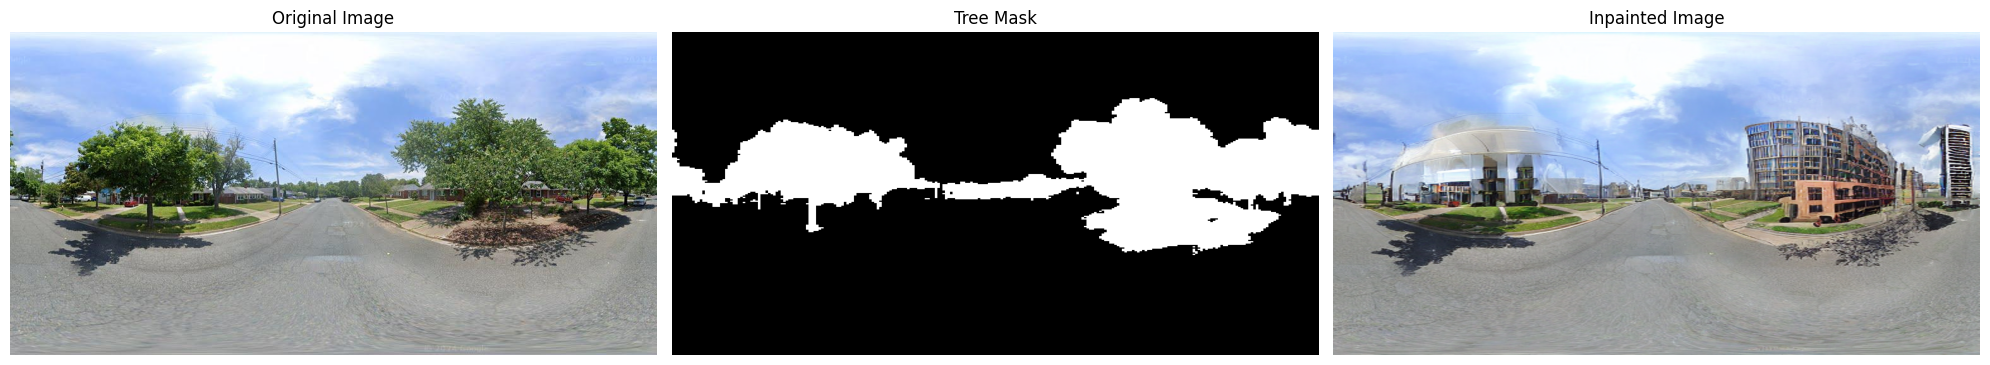

In [2]:
import os
import import_ipynb
import RemoveTrees

def create_tree_non_tree_segmentation_maps(simple_name):
    # make sure the segmentation maps are generated for each panoramic image
    base_directory = f"../data/{simple_name}/{simple_name}_panoramic_imgs"
    panoramic_imgs_directory = f"{base_directory}/panoramic_imgs"
    segmentation_map_output_directory = f"{base_directory}/panoramic_segmentation_maps"

    # make sure directory exists
    os.makedirs(f"{base_directory}\panoramic_segmentation_maps", exist_ok=True)

    for filename in os.listdir(panoramic_imgs_directory):
        name = filename.split(".")[0]
        save_file = f"{segmentation_map_output_directory}\{name}.png"
        # this saves the segmentation_map to the save_file
        convert_image_to_segmentation_maps(f"{panoramic_imgs_directory}\{filename}", save_file)
        print(f"Saved segmentation map: {save_file}")       



if __name__ == "__main__":
    # create_tree_non_tree_segmentation_maps("fredericksburg")
    RemoveTrees.get_remove_trees_panoramic("../data/fredericksburg/fredericksburg_panoramic_imgs/panoramic_imgs/_XUDdpgmLQoSH8kNqmK2mg.jpg")